# Chapter 10. Working With Data

## Exploring Your Data

### Exploring One-Dimensional Data

The simplest case is when you have a one-dimensional data set, which is just a collection of numbers.  
A good first step is to compute some summary statistics, such as the number of data points, the smallest, the largest, the mean, and the standard deviation.  
A good next step is to create a histogram where your data are grouped into discrete *buckets*.

In [218]:
import math
import matplotlib.pyplot as plt
from collections import Counter
from __future__ import division

def bucketize(point, bucket_size):
    """ floor the point to the next lower multiple of bucket_size """
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """ put the points in buckets and count how many in each bucket """
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

For example, consider the following two sets of data:

In [219]:
import random
from probability import inverse_normal_cdf

random.seed(0)

# uniform distribution between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distibution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

Both have means close to 0 and standard deviations close to 58.  
However, they have very different distributions.

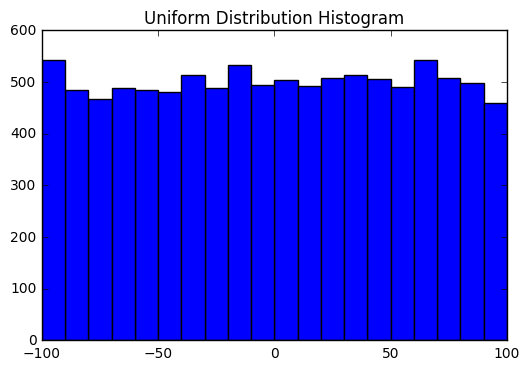

In [220]:
plot_histogram(uniform, 10, "Uniform Distribution Histogram")

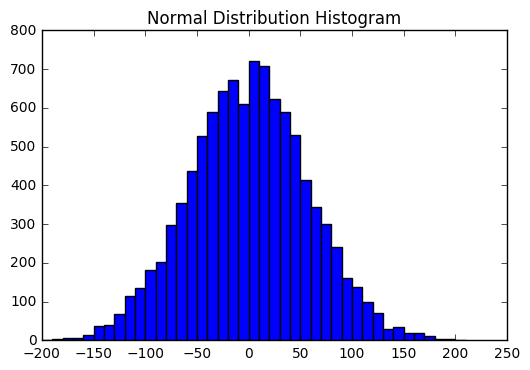

In [221]:
plot_histogram(normal, 10, "Normal Distribution Histogram")

In this case, both distributions had a pretty different `max` and `min`, but even knowing that would not have been sufficient to understand *how* they differed without plotting the data.

### Two Dimensions

When you have a data set with two dimensions, you want to understand each dimension individually, but you would also want to scatter the data.  
To illustrate the idea of scattering the data, let's create a two-dimensional data set:

In [222]:
def random_normal():
    """ returns a random draw from a standard normal distribution """
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(5000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

When you run `plot_histogram` on `ys1` and `ys2`, you get very similar looking plots because they are both normally distributed with the same mean and standard deviation.

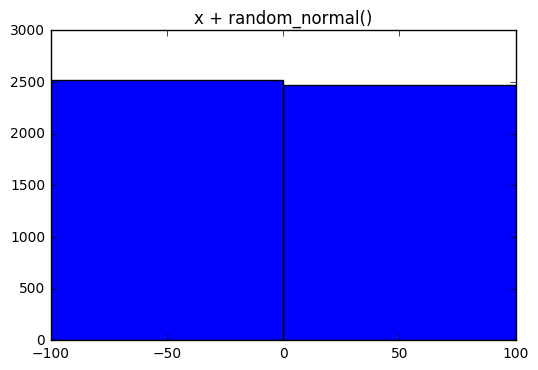

In [223]:
plot_histogram(ys1, 100, "x + random_normal()")

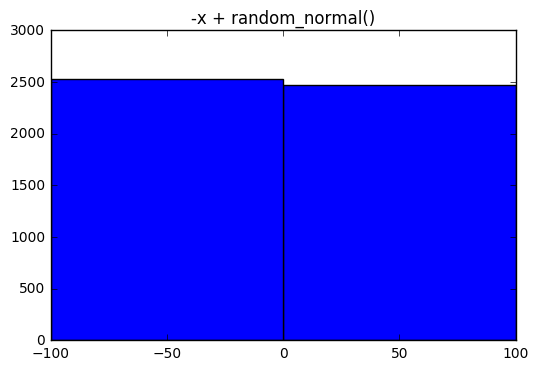

In [224]:
plot_histogram(ys2, 100, "-x + random_normal()")

However, each has a very different joint distribution with `xs`, as we shall illustrate below:

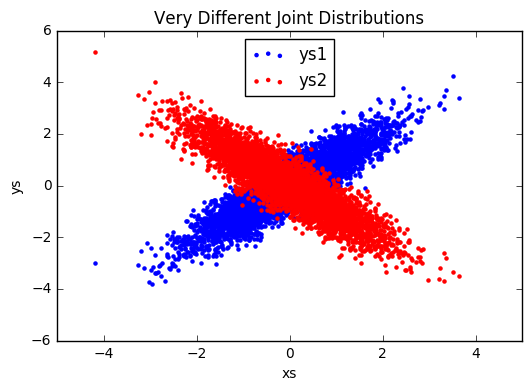

In [225]:
plt.scatter(xs, ys1, marker='.', color='blue', label='ys1')
plt.scatter(xs, ys2, marker='.', color='red', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

The differences are also made apparent when you examine the correlations:

In [226]:
from statistics import correlation

print correlation(xs, ys1)

0.897293439441


In [227]:
print correlation(xs, ys2)

-0.890919845742


### Many Dimensions

With many dimensions, one would like to know how all of the dimensions relate to one another.  
A fairly straightforward approach is to look at the [correlation matrix](https://en.wikipedia.org/wiki/Covariance_matrix#Correlation_matrix), in which the entry in row *i* and column *j* is the correlation between the *i*th dimension and the *j*th dimension of the data:

In [228]:
from linear_algebra import get_column, make_matrix

def correlation_matrix(data):
    """ returns the num_columns by num_columns matrix whose (i,j)th entry is
        the correlation between columns i and j of data"""
    _, num_columns = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)

A more visual approach (if you don't have too many dimensions) is to make a [scatterplot matrix](http://www.itl.nist.gov/div898/handbook/eda/section3/eda33qb.htm) showing all of the pairwise scatterplots.  
To do that we'll use `plt.subplots()`, which allows us to create subplots of our chart.  
We input the number of rows and the number of columns, and a `figure` object is returned (which we won't use) as well as a two-dimensional array of `axes` objects (each of which we will plot to):

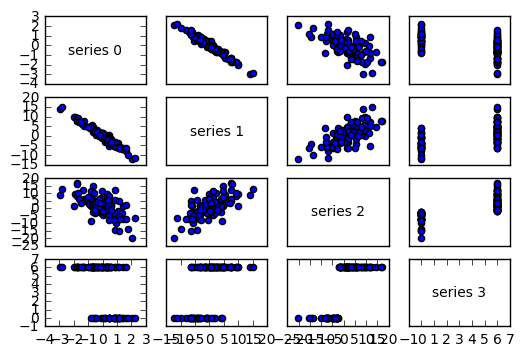

In [229]:
import matplotlib.pyplot as plt
from linear_algebra import shape

num_points = 100

def random_row():
    row = [None, None, None, None]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    return row

random.seed(0)
data = [random_row() for _ in range(num_points)]

_, num_columns = shape(data)
fig, ax = plt.subplots(num_columns, num_columns)

for i in range(num_columns):
    for j in range(num_columns):
        # scatter column_j on the x-axis vs column_i on the y-axis
        if i != j:
            ax[i][j].scatter(get_column(data, j), get_column(data, i))
        # unless i == j, in which case show the series name
        else:
            ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                              xycoords='axes fraction',
                              ha="center", va="center")
        # then hide axis labls except left and bottom charts
        if i < num_columns - 1:
            ax[i][j].xaxis.set_visible(False)
        if j > 0:
            ax[i][j].yaxis.set_visible(False)

# fix the bottom right and top left axis labels, which are wrong because their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

Looking at the scatterplots, you can see that:
- series 1 is very negatively correlated with series 0
- series 2 is positively correlated with series 1
- series 3 only takes on the values 0 and 6, with 0 corresponding to small values of series 2 and 6 corresponding to large values  

This is a quick way to get a rough sense of which of your variables are correlated.

## Cleaning and Munging

Real world data is *dirty*, so you will usually have to do some work on it before you can use it.  
In the stock prices example from Chapter 9, we had to convert strings to `floats` or `ints` right before we used the data, like so:

However, it is probably less error-prone to do the parsing on the way in, which we can do by creating a function that wraps `csv.reader`.  
We'll give it a list of parsers, each specifying how to parse one of the columns.  
`None` will be used to indicate "don't do anything to this column".

In [230]:
def parse_row(input_row, parsers):
    """ given a list of parsers, some of which may be 'None', 
        apply the appropriate one to each element of the input row """
    # beacuse list comprehensions are way cool
    return [parser(value) if parser is not None else value for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """ wrap a reader to apply the parsers to each of its rows """
    for row in reader:
        yield parse_row(row, parsers)

What happens if there is bad data, like a "float" value that doesn't actually represent a number?  
Getting a `None` is preferable to crashing our program, so let's implement a helper function that does this:

In [231]:
def try_or_none(f):
    """ wraps f to return None if f raises an exception """
    """ assume that f takes only one input """
    def f_or_none(x):
        try: 
            return f(x)
        except:
            return None
    return f_or_none

Now, we can rewrite `parse_row()` to use `try_or_none()`:

In [232]:
def parse_row(input_row, parsers):
    """ given a list of parsers, some of which may be 'None', 
        apply the appropriate one to each element of the input row """
    # beacuse list comprehensions are still way cool
    return [try_or_none(parser)(value) if parser is not None else 
            value for value, parser in zip(input_row, parsers)]

For example, if we have comma-delimited stock prices with bad data (in the file named `missing_value.csv`), we can read the file and parse the data in a single step:

In [233]:
import csv
import dateutil.parser
from pprint import pprint as pprint

data = []

with open("bad_values.csv", "rb") as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader,[dateutil.parser.parse, None, float]):
        data.append(line)
        
pprint(data)

[[datetime.datetime(2014, 6, 20, 0, 0), 'AAPL', 90.91],
 [datetime.datetime(2014, 6, 20, 0, 0), 'MSFT', 41.68],
 [datetime.datetime(3014, 6, 20, 0, 0), 'FB', 64.5],
 [datetime.datetime(2014, 6, 19, 0, 0), 'AAPL', 91.86],
 [datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None],
 [datetime.datetime(2014, 6, 19, 0, 0), 'FB', 64.34]]


after which we just need to check for `None` rows:

In [234]:
for row in data:
    if any(x is None for x in row):
        print row

[datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None]


and decide what you can do with them.  
Generally speaking, the three options for dealing with the `None` rows are:
- get rid of them 
- go back to the source and try to fix the bad or missing data 
- cross your fingers, run the code, and hope for the best  


We can create similar helpers for `csv.DictReader`.  
In that case, you would probably want to supply a `dict` of parsers by field name.  
For example:

In [235]:
def try_parse_field(field_name, value, parser_dict):
    """ try to parse value using the appropriate function from parser_dict """
    parser = parser_dict.get(field_name)  # None if there is no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict)
             for field_name, value in input_dict.iteritems() }

A good next step is to check for outliers, using techniques from "Exploring Your Data" or by ad hoc investigating.  
For example, did you notice that one of the dates in the `bad_values.csv` file had the year 3014?  
That won't (necessarily) give you an error, but it will foul up your results if you don't catch it.  
Real-world data sets have missing decimal points, extra zeroes, typos, and myriad other problems that must be identified and dealt with.

## Manipulating Data

Manipulating data is a very important skill, and the best way to learn it (like most everything else in this book) is to work through (a lot of) examples.  
Imagine that we're working with `dicts` of stock prices that look like:

In [236]:
import datetime

data = [
    {'closing_price': 102.13,
     'date': datetime.datetime(2014, 8, 27, 0, 0),
     'symbol': 'AAPL'},
    {'closing_price': 102.25,
     'date': datetime.datetime(2014, 8, 28, 0, 0),
     'symbol': 'AAPL'},
    {'closing_price': 102.50,
     'date': datetime.datetime(2014, 8, 29, 0, 0),
     'symbol': 'AAPL'},
    {'closing_price': 44.87,
     'date': datetime.datetime(2014, 8, 27, 0, 0),
     'symbol': 'MSFT'},
    {'closing_price': 44.88,
     'date': datetime.datetime(2014, 8, 28, 0, 0),
     'symbol': 'MSFT'},
    {'closing_price': 45.43,
     'date': datetime.datetime(2014, 8, 29, 0, 0),
     'symbol': 'MSFT'},
]
# You can find real-world stock price data at Google Finance or Yahoo Finance, among many others.
# There is also a file called 'stocks.txt' in the main directory that has closing prices for AAPL, FB, and MSFT.
data

[{'closing_price': 102.13,
  'date': datetime.datetime(2014, 8, 27, 0, 0),
  'symbol': 'AAPL'},
 {'closing_price': 102.25,
  'date': datetime.datetime(2014, 8, 28, 0, 0),
  'symbol': 'AAPL'},
 {'closing_price': 102.5,
  'date': datetime.datetime(2014, 8, 29, 0, 0),
  'symbol': 'AAPL'},
 {'closing_price': 44.87,
  'date': datetime.datetime(2014, 8, 27, 0, 0),
  'symbol': 'MSFT'},
 {'closing_price': 44.88,
  'date': datetime.datetime(2014, 8, 28, 0, 0),
  'symbol': 'MSFT'},
 {'closing_price': 45.43,
  'date': datetime.datetime(2014, 8, 29, 0, 0),
  'symbol': 'MSFT'}]

Think of this data as rows in a spreadsheet, and start asking questions about this data.  
For example, suppose that we want to know the highest-ever closing price for AAPL.  
Let's break this down into simple, concrete steps:
1. Restrict ourselves to AAPL rows.
2. Get the `closing_price` from each row.
3. Take the `max` of those prices.  

We can do all three using a list comprehension:

In [237]:
max_aapl_price = max(row["closing_price"]
                     for row in data
                     if row["symbol"] == "AAPL")

max_aapl_price

102.5

More generally, we might want to know the highest-ever closing price for each stock in our data set.  
One way to go about doing this is:
1. Group together all of the rows with the same `symbol`.
2. Within each group, take the `max` of those values inthe same manner of `max_aapl_price`.

In [238]:
from collections import defaultdict

# group rows by symbol
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row["symbol"]].append(row)
    
# use a list comprehension to find the max for each symbol
max_price_by_symbol = { symbol : max(row["closing_price"]
                        for row in grouped_rows)
                        for symbol, grouped_rows in by_symbol.iteritems() }

max_price_by_symbol

{'AAPL': 102.5, 'MSFT': 45.43}

Let's examine the patterns shown in the previous examples.  
In both examples, we needed to pull the `closing_price` value out of every `dict`.  
Let's now create a function to pick a field out of a `dict`, and another function to pluck the same field out of a collection of `dicts`:

In [239]:
def picker(field_name):
    """ returns a function that picks a field out of a dict """
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """ turn a list of dicts into the list of field_name values """
    return map(picker(field_name), rows)

We can also create a function to group rows by the result of a `grouper` function and to optionally apply some sort of `value_transform` to each group:

In [240]:
def group_by(grouper, rows, value_transform=None):
    """ key is the output of grouper, value is the list of rows """
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows) for key, rows in grouped.iteritems() }

This allows us two rewrite our previous examples in a simpler way.  
For example:

In [241]:
max_price_by_symbol = group_by(picker("symbol"), data,
                      lambda rows: max(pluck("closing_price", rows)))

max_price_by_symbol

{'AAPL': 102.5, 'MSFT': 45.43}

Now we can move on to more complex queries, like what are the largest and smallest one-day percent changes in our data set.  
The percent change is `price_today / price_yesterday -1`, which means that we need some way of associating today's price and yesterday's price.  
One approach is to group the prices by symbol, and then, within each group:
1. Order the prices by date.
2. Use `zip` to get pairs(previous, current).
3. Turn the pairs into new "percent change" rows.  

Let's start by writing a function to do all of the 'within-each-group' work:

In [242]:
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] -1

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"],
              "date"   : today["date"],
              "change" : percent_price_change(yesterday, today) }
              for yesterday, today in zip(ordered, ordered[1:])]

Then we can just use this as the `value_transform` in a `group_by`:

In [243]:
# key is symbol, value is a list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)
changes_by_symbol

{'AAPL': [{'change': 0.0011749730735337582,
   'date': datetime.datetime(2014, 8, 28, 0, 0),
   'symbol': 'AAPL'},
  {'change': 0.0024449877750611915,
   'date': datetime.datetime(2014, 8, 29, 0, 0),
   'symbol': 'AAPL'}],
 'MSFT': [{'change': 0.00022286605749965993,
   'date': datetime.datetime(2014, 8, 28, 0, 0),
   'symbol': 'MSFT'},
  {'change': 0.01225490196078427,
   'date': datetime.datetime(2014, 8, 29, 0, 0),
   'symbol': 'MSFT'}]}

In [244]:
# collect all "change" dicts into one big list
all_changes = [change for changes in changes_by_symbol.values() for change in changes]
all_changes

[{'change': 0.0011749730735337582,
  'date': datetime.datetime(2014, 8, 28, 0, 0),
  'symbol': 'AAPL'},
 {'change': 0.0024449877750611915,
  'date': datetime.datetime(2014, 8, 29, 0, 0),
  'symbol': 'AAPL'},
 {'change': 0.00022286605749965993,
  'date': datetime.datetime(2014, 8, 28, 0, 0),
  'symbol': 'MSFT'},
 {'change': 0.01225490196078427,
  'date': datetime.datetime(2014, 8, 29, 0, 0),
  'symbol': 'MSFT'}]

Now we can find the largest and smallest changes:

In [245]:
max(all_changes, key=picker("change"))

{'change': 0.01225490196078427,
 'date': datetime.datetime(2014, 8, 29, 0, 0),
 'symbol': 'MSFT'}

In [246]:
min(all_changes, key=picker("change"))

{'change': 0.00022286605749965993,
 'date': datetime.datetime(2014, 8, 28, 0, 0),
 'symbol': 'MSFT'}

Now we can use this new `all_changes` data set to find out which month has been the best to invest in tech stocks.  
First, group the changes by month, then compute the overall change within each group.  
Once again, we write an appropriate `value_transform` and then use `group_by`:

In [247]:
# to combine the percent changes, add 1 to each instance, multiply them, and subtract 1
# for example, if we combine +10% and -20%, the overall change is:
# (1 + 10%) * (1 - 20%) -1 =  1.1 * .8 -1 =  -12%
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) -1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row['date'].month, all_changes, overall_change)

overall_change_by_month

{8: 0.016148547635825183}

### Experiment with data from Google Finance

Time to detour for a bit of an experiment with what we have learned so far.  
I have taken the past year's worth of data on stock prices for Amazon, Apple, Facebook, Google, and Microsoft.  
Let's see if we can't clean up the data and apply our data manipulation functions to it.

For starters, let's append the five separate `csv` files containing each company's data into one `Pandas` `DataFrame`:

In [248]:
import pandas as pd

big_5_frame = pd.DataFrame()
company_list = []
# import each company's csv file
aapl = pd.read_csv('aapl.csv')
# add column containing each company's stock ticker symbol
aapl['Symbol'] = pd.Series('AAPL', index=aapl.index)
# append each csv file to a bigger list containing data for all 5 companies
company_list.append(aapl)

# repeat for each company
amzn = pd.read_csv('amzn.csv')
amzn['Symbol'] = pd.Series('AMZN', index=amzn.index)
company_list.append(amzn)
fb = pd.read_csv('fb.csv')
fb['Symbol'] = pd.Series('FB', index=fb.index)
company_list.append(fb)
goog = pd.read_csv('goog.csv')
goog['Symbol'] = pd.Series('GOOG', index=goog.index)
company_list.append(goog)
msft = pd.read_csv('msft.csv')
msft['Symbol'] = pd.Series('MSFT', index=msft.index)
company_list.append(msft)

# check to see what our data looks like
print aapl[:10]
print msft[:10]

# convert master list to Pandas DataFrame
big_5_frame = pd.concat(company_list)

# view the results
print big_5_frame.head(10)
print big_5_frame.tail(10)
big_5_frame.describe()

        Date    Open    High     Low   Close    Volume Symbol
0  13-Dec-16  113.84  115.92  113.75  115.19  43733811   AAPL
1  12-Dec-16  113.29  115.00  112.49  113.30  26374377   AAPL
2   9-Dec-16  112.31  114.70  112.31  113.95  34402627   AAPL
3   8-Dec-16  110.86  112.43  110.60  112.12  27068316   AAPL
4   7-Dec-16  109.26  111.19  109.16  111.03  29998719   AAPL
5   6-Dec-16  109.50  110.36  109.19  109.95  26195462   AAPL
6   5-Dec-16  110.00  110.03  108.25  109.11  34324540   AAPL
7   2-Dec-16  109.17  110.09  108.85  109.90  26527997   AAPL
8   1-Dec-16  110.36  110.94  109.03  109.49  37086862   AAPL
9  30-Nov-16  111.60  112.20  110.27  110.52  36162258   AAPL
        Date   Open   High    Low  Close    Volume Symbol
0  13-Dec-16  62.50  63.42  62.24  62.98  35718868   MSFT
1  12-Dec-16  61.82  62.30  61.72  62.17  20198081   MSFT
2   9-Dec-16  61.18  61.99  61.12  61.97  27349356   MSFT
3   8-Dec-16  61.30  61.58  60.84  61.01  21220753   MSFT
4   7-Dec-16  60.01  61.38  

,Open,High,Low,Close,Volume
count,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,342.554685,345.408996,339.398805,342.509737,2.033648e+07
std,311.352684,313.754486,308.649426,311.252684,1.930814e+07
min,48.680000,49.150000,48.040000,48.430000,5.272230e+05
25%,96.785000,97.880000,95.675000,96.830000,3.003518e+06
50%,117.700000,118.360000,116.730000,117.580000,1.885642e+07
75%,716.495000,721.415000,710.455000,715.445000,3.016828e+07
max,845.790000,847.210000,840.600000,844.360000,1.335030e+08


Now that we have all of our data in a  `Pandas` `DataFrame`, it's time to reset the index (to eliminate duplicate index values) and keep only the columns that we need to perform our calculations.

In [249]:
# Make a copy of the original dataframe to rearrange our data
big_5_copy = big_5_frame.copy()

# reset index so there are no duplicate index values
big_5_copy = big_5_copy.reset_index()

# create new dataframe that will contain only the date, closing price, and ticker symbol
relevant_values = pd.DataFrame()
relevant_values['date'] = big_5_copy['Date']
relevant_values['closing_price'] = big_5_copy['Close']
relevant_values['symbol'] = big_5_copy['Symbol']
print relevant_values.columns
relevant_values.tail(10)

Index([u'date', u'closing_price', u'symbol'], dtype='object')


,date,closing_price,symbol
1245,30-Dec-15,56.31,MSFT
1246,29-Dec-15,56.55,MSFT
1247,28-Dec-15,55.95,MSFT
1248,24-Dec-15,55.67,MSFT
1249,23-Dec-15,55.82,MSFT
1250,22-Dec-15,55.35,MSFT
1251,21-Dec-15,54.83,MSFT
1252,18-Dec-15,54.13,MSFT
1253,17-Dec-15,55.70,MSFT
1254,16-Dec-15,56.13,MSFT


Our `date` column is currently a string that can be converted to a datetime object using `Pandas`:

In [250]:
# convert Pandas Series containing dates to datetime objects
relevant_values['date'] = pd.to_datetime(relevant_values['date'])
relevant_values['date'][1]

Timestamp('2016-12-12 00:00:00')

Our data from the `Manipulating` `Data` section is a list of dictionaries.  
Converting our dataframe to JSON should give us something similar.

In [251]:
# convert relevant values dataframe to JSON
json_data = relevant_values.to_json(orient='index')
json_data[:1000]

'{"0":{"date":1481587200000,"closing_price":115.19,"symbol":"AAPL"},"1":{"date":1481500800000,"closing_price":113.3,"symbol":"AAPL"},"2":{"date":1481241600000,"closing_price":113.95,"symbol":"AAPL"},"3":{"date":1481155200000,"closing_price":112.12,"symbol":"AAPL"},"4":{"date":1481068800000,"closing_price":111.03,"symbol":"AAPL"},"5":{"date":1480982400000,"closing_price":109.95,"symbol":"AAPL"},"6":{"date":1480896000000,"closing_price":109.11,"symbol":"AAPL"},"7":{"date":1480636800000,"closing_price":109.9,"symbol":"AAPL"},"8":{"date":1480550400000,"closing_price":109.49,"symbol":"AAPL"},"9":{"date":1480464000000,"closing_price":110.52,"symbol":"AAPL"},"10":{"date":1480377600000,"closing_price":111.46,"symbol":"AAPL"},"11":{"date":1480291200000,"closing_price":111.57,"symbol":"AAPL"},"12":{"date":1480032000000,"closing_price":111.79,"symbol":"AAPL"},"13":{"date":1479859200000,"closing_price":111.23,"symbol":"AAPL"},"14":{"date":1479772800000,"closing_price":111.8,"symbol":"AAPL"},"15":{

Close, but 'data' is a Python string containing key-value pairs.  
Our next step is to convert that string to a dictionary.

In [252]:
import json

d = json.loads(json_data)
type(d)

dict

Almost there.  
We just need to create a list in which we can nest our dictionaries containing the daily stock prices for each company:

In [253]:
new_dataset = d.values()
new_data = []
for item in new_dataset:
    new_data.append(item)

print(type(new_data))
new_data[:5]

<type 'list'>


[{u'closing_price': 51.03, u'date': 1457308800000, u'symbol': u'MSFT'},
 {u'closing_price': 54.65, u'date': 1460419200000, u'symbol': u'MSFT'},
 {u'closing_price': 55.23, u'date': 1459382400000, u'symbol': u'MSFT'},
 {u'closing_price': 52.12, u'date': 1464134400000, u'symbol': u'MSFT'},
 {u'closing_price': 49.87, u'date': 1461888000000, u'symbol': u'MSFT'}]

The list of dicitionaries is almost ready to be queried, but the date column needs to be formatted to distinguish between days and months (as well as years):

In [254]:
for item in new_data:
    item['date'] = datetime.datetime.fromtimestamp(item['date'] / 1e3)
    
new_data[:5]

[{u'closing_price': 51.03,
  u'date': datetime.datetime(2016, 3, 6, 16, 0),
  u'symbol': u'MSFT'},
 {u'closing_price': 54.65,
  u'date': datetime.datetime(2016, 4, 11, 17, 0),
  u'symbol': u'MSFT'},
 {u'closing_price': 55.23,
  u'date': datetime.datetime(2016, 3, 30, 17, 0),
  u'symbol': u'MSFT'},
 {u'closing_price': 52.12,
  u'date': datetime.datetime(2016, 5, 24, 17, 0),
  u'symbol': u'MSFT'},
 {u'closing_price': 49.87,
  u'date': datetime.datetime(2016, 4, 28, 17, 0),
  u'symbol': u'MSFT'}]

We have the data in a format that we can run our functions on.  
The data is out of order because it is a list of dictionaries, but we should still be able to get the results that we want.  
Now it is time to execute the functions we wrote for the section on `Manipulating` `Data` on the aggregated data we have created.

In [255]:
# pick one of the five companies and find the highest closing_price
max_amazon_price = max(row["closing_price"]
                     for row in new_data
                     if row["symbol"] == "AMZN")

max_amazon_price

844.36

In [256]:
# find the max price for each company in our aggregated dataset
from collections import defaultdict

# group rows by symbol
by_symbol = defaultdict(list)
for row in new_data:
    by_symbol[row["symbol"]].append(row)
    
# use a list comprehension to find the max for each symbol
max_price_by_symbol = { symbol : max(row["closing_price"]
                        for row in grouped_rows)
                        for symbol, grouped_rows in by_symbol.iteritems() }

max_price_by_symbol

{u'AAPL': 118.25,
 u'AMZN': 844.36,
 u'FB': 133.28,
 u'GOOG': 813.11,
 u'MSFT': 62.98}

In [257]:
def picker(field_name):
    """ returns a function that picks a field out of a dict """
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """ turn a list of dicts into the list of field_name values """
    return map(picker(field_name), rows)

In [258]:
def group_by(grouper, rows, value_transform=None):
    """ key is the output of grouper, value is the list of rows """
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows) for key, rows in grouped.iteritems() }

In [259]:
max_price_by_symbol = group_by(picker("symbol"), new_data,
                      lambda rows: max(pluck("closing_price", rows)))

max_price_by_symbol

{u'AAPL': 118.25,
 u'AMZN': 844.36,
 u'FB': 133.28,
 u'GOOG': 813.11,
 u'MSFT': 62.98}

In [260]:
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] -1

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"],
              "date"   : today["date"],
              "change" : percent_price_change(yesterday, today) }
              for yesterday, today in zip(ordered, ordered[1:])]

In [261]:
changes_by_symbol = group_by(picker("symbol"), new_data, day_over_day_changes)
changes_by_symbol.keys()

[u'GOOG', u'FB', u'AAPL', u'AMZN', u'MSFT']

In [262]:
all_changes = [change for changes in changes_by_symbol.values() for change in changes]
all_changes[:5]

[{'change': -0.011423445765014861,
  'date': datetime.datetime(2015, 12, 16, 16, 0),
  'symbol': u'GOOG'},
 {'change': -0.01350359606634377,
  'date': datetime.datetime(2015, 12, 17, 16, 0),
  'symbol': u'GOOG'},
 {'change': 0.011443102352193257,
  'date': datetime.datetime(2015, 12, 20, 16, 0),
  'symbol': u'GOOG'},
 {'change': 0.0029822004092168175,
  'date': datetime.datetime(2015, 12, 21, 16, 0),
  'symbol': u'GOOG'},
 {'change': 0.0004133333333331546,
  'date': datetime.datetime(2015, 12, 22, 16, 0),
  'symbol': u'GOOG'}]

In [263]:
# largest single day gain
max(all_changes, key=picker("change"))

{'change': 0.15521439915299107,
 'date': datetime.datetime(2016, 1, 27, 16, 0),
 'symbol': u'FB'}

In [264]:
# largest single day loss
min(all_changes, key=picker("change"))

{'change': -0.07609978751869051,
 'date': datetime.datetime(2016, 1, 28, 16, 0),
 'symbol': u'AMZN'}

In [265]:
# compute aggregated gains and losses over the course of each month for all 5 companies.
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) -1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row['date'].month, all_changes, overall_change)

overall_change_by_month

{1: -0.16280051906947135,
 2: -0.07941953958735881,
 3: 0.3177380453266183,
 4: -0.21084579920126678,
 5: 0.29932019952785827,
 6: -0.12932277452074536,
 7: 0.5571168619265165,
 8: 0.03806876561283845,
 9: 0.18319264043536498,
 10: -0.022502263013667423,
 11: -0.2191062422303185,
 12: 0.18893036663098384}

In [266]:
max(overall_change_by_month)

12

In [267]:
min(overall_change_by_month)

1

Over the past year, it appears that December (the last half of 2015 and the first half of 2016, anyway) has been the best month for the 5 stocks selected, and January (2015) was the worst.  
Let's put up a (very) simple plot showing the volatility of closing prices of our five companies over the past year:

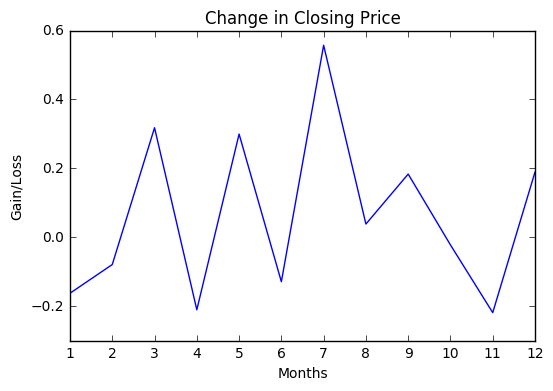

In [268]:
import numpy as np
import matplotlib.pyplot as plt

f, ax = plt.subplots(1)
x = overall_change_by_month.keys()
y = overall_change_by_month.values()
ax.plot(x, y)
dim=np.arange(1,13,1)
plt.xticks(dim)
ax.set_xlim(xmin=1)
plt.title("Change in Closing Price")
plt.xlabel("Months")
plt.ylabel("Gain/Loss")
plt.show(f)

## Rescaling

Many techniques are sensitive to the *scale* of your data.  
For example, imagine that you have a data set consisting of the heights and weights of hundreds of data scientists, and that you are trying to identify *clusters* of body sizes.  
Intuitively, we'd like the clusters to represent points near each other, which means that we need some notion of distance between points.  
We already have a Euclidean `distance` function, so a natural approach might be to treat (`height`, `weight`) pairs as points in two-dimensional space.  
Consider the people listed below:

If we measure height in inches, then B's nearest neighbor is A:

In [269]:
from linear_algebra import distance

a_to_b = distance([63, 150], [67, 160])
print "A to B is " + str(a_to_b)
a_to_c = distance([63, 150], [70, 171])
print "A to C is " + str(a_to_c)
b_to_c = distance([67, 160], [70, 171])
print "B to C is " + str(b_to_c)

A to B is 10.7703296143
A to C is 22.1359436212
B to C is 11.401754251


However, if we measure height in centimeters instead, then B's nearest neighbor is now C:

In [270]:
a_to_b = distance([160, 150], [170.2, 160])
print "A to B is " + str(a_to_b)
a_to_c = distance([160, 150], [177.8, 171])
print "A to C is " + str(a_to_c)
b_to_c = distance([170.2, 160], [177.8, 171])
print "B to C is " + str(b_to_c)

A to B is 14.2842570685
A to C is 27.5288939117
B to C is 13.3701159307


If changing units can change results, then we have a problem that must be dealt with.  
For this reason, when dimensions aren't comparable with one another, we will sometimes *rescale* our data so that each dimension has mean 0 and standard deviation 1.  
This technique effectively eliminates the units, and each dimension is converted to "standard deviations from the mean".  
To start with, we'll need to compute the `mean` and `standard deviation` for each column:

In [271]:
from statistics import mean, standard_deviation

def scale(data_matrix):
    """ returns the means and standard deviations of each column """
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j)) for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j)) for j in range(num_cols)]
    return means, stdevs

And then use them to create a new data matrix:

In [272]:
def rescale(data_matrix):
    """ rescales the input data so that each column has mean 0 and standard deviation 1
        while columns with no deviation remain unchanged """
    means, stdevs = scale(data_matrix)
    
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j] / stdevs[j])
        else:
            return data_matrix[i][j]
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

In [273]:
print "rescaling"
print
data = [[1, 20, 2],
        [1, 30, 3],
        [1, 40, 4]]

print "original: ", data
print
print "scale: ", scale(data)
print
print "rescaled: ", rescale(data)
print

rescaling

original:  [[1, 20, 2], [1, 30, 3], [1, 40, 4]]

scale:  ([1.0, 30.0, 3.0], [0.0, 10.0, 1.0])

rescaled:  [[1, 17.0, -1.0], [1, 27.0, 0.0], [1, 37.0, 1.0]]



As always, you need to use your judgment.  
If you were to take a huge data set of heights and weights and filter it down to to only the people with heights between 69.5 inches and 70.5 inches, it is quite likely (depending on the question you're trying to answer) that the variation remaining is simply *noise*, and you may not want to put its standard deviation on equal footing with other dimensions' deviations.

## Dimensionality Reduction

Sometimes, the "actual" (or useful) dimensions of the data might not correspond to the dimensions we have.  
For example, consider the data set pictured below:

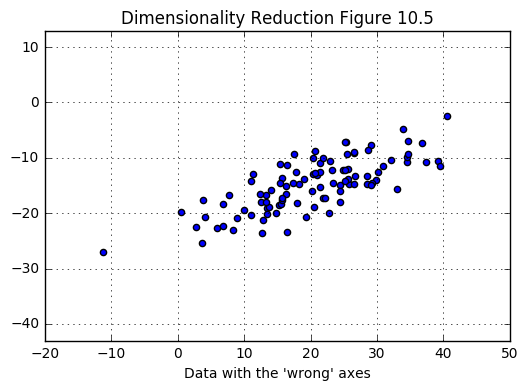

In [274]:
X = [
    [20.9666776351559,-13.1138080189357],
    [22.7719907680008,-19.8890894944696],
    [25.6687103160153,-11.9956004517219],
    [18.0019794950564,-18.1989191165133],
    [21.3967402102156,-10.8893126308196],
    [0.443696899177716,-19.7221132386308],
    [29.9198322142127,-14.0958668502427],
    [19.0805843080126,-13.7888747608312],
    [16.4685063521314,-11.2612927034291],
    [21.4597664701884,-12.4740034586705],
    [3.87655283720532,-17.575162461771],
    [34.5713920556787,-10.705185165378],
    [13.3732115747722,-16.7270274494424],
    [20.7281704141919,-8.81165591556553],
    [24.839851437942,-12.1240962157419],
    [20.3019544741252,-12.8725060780898],
    [21.9021426929599,-17.3225432396452],
    [23.2285885715486,-12.2676568419045],
    [28.5749111681851,-13.2616470619453],
    [29.2957424128701,-14.6299928678996],
    [15.2495527798625,-18.4649714274207],
    [26.5567257400476,-9.19794350561966],
    [30.1934232346361,-12.6272709845971],
    [36.8267446011057,-7.25409849336718],
    [32.157416823084,-10.4729534347553],
    [5.85964365291694,-22.6573731626132],
    [25.7426190674693,-14.8055803854566],
    [16.237602636139,-16.5920595763719],
    [14.7408608850568,-20.0537715298403],
    [6.85907008242544,-18.3965586884781],
    [26.5918329233128,-8.92664811750842],
    [-11.2216019958228,-27.0519081982856],
    [8.93593745011035,-20.8261235122575],
    [24.4481258671796,-18.0324012215159],
    [2.82048515404903,-22.4208457598703],
    [30.8803004755948,-11.455358009593],
    [15.4586738236098,-11.1242825084309],
    [28.5332537090494,-14.7898744423126],
    [40.4830293441052,-2.41946428697183],
    [15.7563759125684,-13.5771266003795],
    [19.3635588851727,-20.6224770470434],
    [13.4212840786467,-19.0238227375766],
    [7.77570680426702,-16.6385739839089],
    [21.4865983854408,-15.290799330002],
    [12.6392705930724,-23.6433305964301],
    [12.4746151388128,-17.9720169566614],
    [23.4572410437998,-14.602080545086],
    [13.6878189833565,-18.9687408182414],
    [15.4077465943441,-14.5352487124086],
    [20.3356581548895,-10.0883159703702],
    [20.7093833689359,-12.6939091236766],
    [11.1032293684441,-14.1383848928755],
    [17.5048321498308,-9.2338593361801],
    [16.3303688220188,-15.1054735529158],
    [26.6929062710726,-13.306030567991],
    [34.4985678099711,-9.86199941278607],
    [39.1374291499406,-10.5621430853401],
    [21.9088956482146,-9.95198845621849],
    [22.2367457578087,-17.2200123442707],
    [10.0032784145577,-19.3557700653426],
    [14.045833906665,-15.871937521131],
    [15.5640911917607,-18.3396956121887],
    [24.4771926581586,-14.8715313479137],
    [26.533415556629,-14.693883922494],
    [12.8722580202544,-21.2750596021509],
    [24.4768291376862,-15.9592080959207],
    [18.2230748567433,-14.6541444069985],
    [4.1902148367447,-20.6144032528762],
    [12.4332594022086,-16.6079789231489],
    [20.5483758651873,-18.8512560786321],
    [17.8180560451358,-12.5451990696752],
    [11.0071081078049,-20.3938092335862],
    [8.30560561422449,-22.9503944138682],
    [33.9857852657284,-4.8371294974382],
    [17.4376502239652,-14.5095976075022],
    [29.0379635148943,-14.8461553663227],
    [29.1344666599319,-7.70862921632672],
    [32.9730697624544,-15.5839178785654],
    [13.4211493998212,-20.150199857584],
    [11.380538260355,-12.8619410359766],
    [28.672631499186,-8.51866271785711],
    [16.4296061111902,-23.3326051279759],
    [25.7168371582585,-13.8899296143829],
    [13.3185154732595,-17.8959160024249],
    [3.60832478605376,-25.4023343597712],
    [39.5445949652652,-11.466377647931],
    [25.1693484426101,-12.2752652925707],
    [25.2884257196471,-7.06710309184533],
    [6.77665715793125,-22.3947299635571],
    [20.1844223778907,-16.0427471125407],
    [25.5506805272535,-9.33856532270204],
    [25.1495682602477,-7.17350567090738],
    [15.6978431006492,-17.5979197162642],
    [37.42780451491,-10.843637288504],
    [22.974620174842,-10.6171162611686],
    [34.6327117468934,-9.26182440487384],
    [34.7042513789061,-6.9630753351114],
    [15.6563953929008,-17.2196961218915],
    [25.2049825789225,-14.1592086208169]
]
points = zip(*X)
f, ax = plt.subplots(1)
x = points[0]
y = points[1]
ax.scatter(x, y)
ax.set_ylim(ymin=-43, ymax=13)
ax.grid(True)
plt.title("Dimensionality Reduction Figure 10.5")
plt.xlabel("Data with the 'wrong' axes")
plt.show(f)

Most of the variation in the data sems to be along a single dimension that doesn't correspond to either the x-axis or the y-axis.  
When this is the case, we can use a technique called [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to extract one or more dimensions that capture as much of the variation in the data as possible.

**Note**  
In practice, you wouldn't ordinarily use PCA on such a low-dimensional dataset.  
Dimensionality reduction is most useful when your data set has a large number of dimensions and you are trying to find a small subset that captures most of the variation.  
Unfortunately, those cases are difficult to illustrate in a 2D book format.

As a first step, we'll need to translate the data so that each dimension has mean zero:

In [275]:
def de_mean_matrix(A):
    """ returns the result of subtracting from every value in A in the mean value of the column """
    """ the resulting matrix has mean 0 in every column """
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])

# If we don't do this, our techniques are likely to identify the mean itself instead of the variation in the data.
de_mean_matrix(X)

[[0.6663708720254604, 1.6869418499129427],
 [2.4716840048703617, -5.088339625620959],
 [5.36840355288486, 2.805149417126742],
 [-2.29832726807404, -3.398169247664656],
 [1.096433447085161, 3.911437238029043],
 [-19.856609863952723, -4.921363369782158],
 [9.61952545108226, 0.7048830186059423],
 [-1.2197224551178394, 1.011875108017442],
 [-3.8318004109990405, 3.5394571654195417],
 [1.1594597070579589, 2.326746410178142],
 [-16.42375392592512, -2.774412592922358],
 [14.27108529254826, 4.095564703470643],
 [-6.927095188358241, -1.9262775805937569],
 [0.42786365106146107, 5.989093953283113],
 [4.539544674811559, 2.676653653106742],
 [0.001647710994760132, 1.9282437907588417],
 [1.601835929829459, -2.5217933707965567],
 [2.928281808418159, 2.533093026944142],
 [8.27460440505466, 1.5391028069033421],
 [8.995435649739662, 0.17075700094904178],
 [-5.05075398326794, -3.6642215585720574],
 [6.2564189769171605, 5.602806363228982],
 [9.89311647150566, 2.1734788842515425],
 [16.526437837975262, 7.54

In the plot below, the points displayed have the same pattern as Figure 10-5, but notice where they fall on the `x` and `y` axes relative to 0:

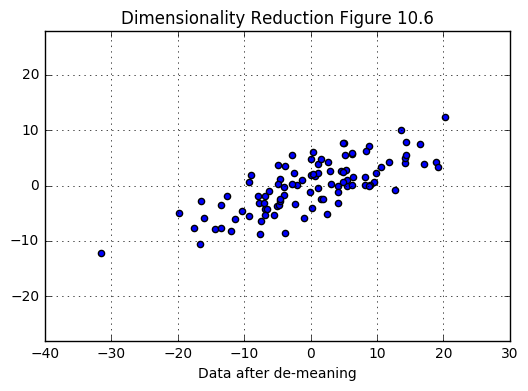

In [276]:
zero_mean_matrix = de_mean_matrix(X)
demean_points = zip(*zero_mean_matrix)
f, ax = plt.subplots(1)
x = demean_points[0]
y = demean_points[1]
ax.scatter(x, y)
ax.set_ylim(ymin=-28, ymax=28)
ax.grid(True)
plt.title("Dimensionality Reduction Figure 10.6")
plt.xlabel("Data after de-meaning")
plt.show(f)

Now then, given a de-meaned matrix `X`, we can ask:  
Which is the direction that captures the greatest variance in the data?

Specifically, given a direction *d* (a vector of magnitude 1), each row *x* in the matrix extends `dot(x, d)` in the *d* direction.  
Also, every nonzero vector *w* determines a direction if we rescale it to have magnitude 1:

In [277]:
from linear_algebra import magnitude

def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

Therefore, given a nonzero vector *w*, we can compute the variance of our data set in the direction determined by *w*:

In [278]:
def directional_variance_i(x_i, w):
    """ the variance of the row x_i in the direction determined by w """
    return dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """ the variance of the data in the direction determined by w """
    return sum(directional_variance_i(x_i, w) for x_i in X)

We want to find the direction that maximizes this variance.  
We can do this using gradient descent, as soon as we have the gradient function:

In [279]:
def directional_variance_gradient_i(x_i, w):
    """ the contribution of row x_i to the gradient of the direction-w variance """
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i, w) for x_i in X)

The first principal component is just the direction that maximizes the `directional_variance()` function:

In [280]:
from gradient_descent import maximize_batch
from functools import partial
from linear_algebra import vector_sum, dot

def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(partial(directional_variance, X),
                                       # is now a function of w
                                        partial(directional_variance_gradient, X),
                                       # is now a function of w
                                        guess)
    return direction(unscaled_maximizer)

first_principal_component(X)

[0.8483153298152323, -0.529491360836486]

Or, if you’d rather use stochastic gradient descent:

Once we have found the direction that is the first principal component, we can project our data on to it in order to find the values of that component:

In [281]:
from linear_algebra import scalar_multiply

def project(v, w):
    """ return the projection of v on to the direction w """
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

If we want to find further components, we first remove the projections from the data:

In [282]:
from linear_algebra import vector_subtract

def remove_projection_from_vector(v, w):
    """ projects v on to w and subtracts the result from v """
    return vector_subtract(v, project(v, w))

def remove_projection(X, w):
    """ for each row in X, project the row on to w and subtract the result from the row """
    return [remove_projection_from_vector(x_i, w) for x_i in X]

Because this example data set is only two-dimensional, after we remove the first components, what remains will be effectively one-dimensional.  
At that point, we can find the next principal component by repeating the process on the result of `remove_projection`.

On a higher-dimensional dataset, we can iteratively find as many components as we want:

In [283]:
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
        
    return components

principal_component_analysis(X,4)

[[0.8483153298152323, -0.529491360836486],
 [0.5294915482155131, 0.8483152128591935],
 [0.7071067811865475, 0.7071067811865475],
 [0.7071067811865475, 0.7071067811865475]]

We can then *transform* our data into the lower-dimensional space spanned by the components:

In [284]:
def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]

transform(zero_mean_matrix, principal_component_analysis(zero_mean_matrix,2))

[[1.2612932692676448, 1.3034686841532082],
 [0.3359590499387566, -5.646899553194867],
 [6.033276222609105, 0.5369662074182702],
 [-3.4239430388465597, -2.2598226350726454],
 [2.5100159771608372, 3.194003882043119],
 [-20.228247245074073, 3.052903115117247],
 [9.156838721553614, -3.0303927867420373],
 [-0.739560422683262, 1.4016495167347736],
 [-2.185331802509928, 4.736490875076623],
 [1.9617159202032295, 1.7058445112731864],
 [-16.235057200294847, 3.7225612426566412],
 [14.751962599801796, -1.6781225818803782],
 [-7.136901049824428, 0.8715375754533754],
 [2.6875599481387695, 5.36935148608874],
 [5.218349781924116, 0.7354765818630526],
 [0.7395414883726974, 1.7808031873862522],
 [0.5146693911735575, -2.9428510955345537],
 [3.674829234132428, 1.219512656422601],
 [8.233616810343257, -1.7449562001303356],
 [8.375837700800835, -3.2849990682366808],
 [-6.068616652493782, -1.4522031123857584],
 [7.924453956919672, 2.781755534677893],
 [9.971690094490134, -1.7783202903924975],
 [18.1564569118

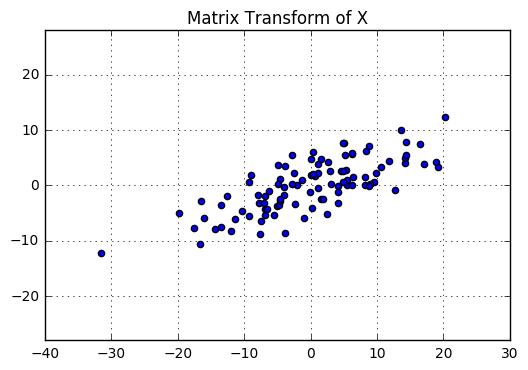

In [285]:
matrix_transform = transform(zero_mean_matrix, principal_component_analysis(zero_mean_matrix,2))
mt_points = zip(*matrix_transform)
f, ax = plt.subplots(1)
x = demean_points[0]
y = demean_points[1]
ax.scatter(x, y)
ax.set_ylim(ymin=-28, ymax=28)
ax.grid(True)
plt.title("Matrix Transform of X")
plt.show(f)

This technique is valuable for a couple of reasons.  
First, it can help us clean our data by eliminating noise(y) dimensions and consolidating dimensions that are highly correlated.  
Second, after extracting a low-dimensional representation of our data, we can use a variety of techniques that *don't* work quite so well on high-dimensional data.  
Just remember that while principal component analysis and dimensionality reduction can help build better models, they can also make those models more difficult to interpret.

## For Further Exploration

- [pandas](http://pandas.pydata.org/)
- [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do)
- [scikit-learn](http://scikit-learn.org/stable/) has a wide variety of [matrix decomposition](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) functions, including PCA.